# Library imports

In [1]:
import torch
import random
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm  # tqdm can be used in for-loops to show a progress bar
from torchvision.datasets.voc import VOCDetection
from torch.utils.data import Dataset, DataLoader
import yaml

import json
import os
import matplotlib.patches as patches
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as plt

from torch import nn
from torch.nn import functional as F

import numpy as np
from datetime import datetime
'''
TensorBoard utilities let you log PyTorch models and metrics during training
into a directory for visualization within the TensorBoard GUI.
The SummaryWriter class is your main "entry point" of the API to log data for
later "consumption" and visualization by TensorBoard.
'''
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'torch'

# Configurations

In [ ]:
DATA_PATH = "G:/Il mio Drive/2. Advanced Programming and Deep Learning/VehiclesDetectionDataset"
SPLIT_TRAIN = "train"
IMAGES_DIR_TRAIN = os.path.join(DATA_PATH, SPLIT_TRAIN, "images")
LABELS_DIR_TRAIN = os.path.join(DATA_PATH, SPLIT_TRAIN, "labels")
SPLIT_TEST = "test"
IMAGES_DIR_TEST = os.path.join(DATA_PATH, SPLIT_TEST, "images")
LABELS_DIR_TEST = os.path.join(DATA_PATH, SPLIT_TEST, "labels")
# YAML delle classi
DATA_YAML = os.path.join(DATA_PATH, "dataset.yaml")
with open(DATA_YAML, "r", encoding="utf-8") as f:
    ycfg = yaml.safe_load(f)

# Leggi i nomi classe
if isinstance(ycfg["names"], dict):
    NAMES = [ycfg["names"][i] for i in sorted(map(int, ycfg["names"].keys()))]
else:
    NAMES = list(ycfg["names"])

# Crea dizionario classi
CLASSES = {name: i for i, name in enumerate(NAMES)}

# salva un classes.json
CLASSES_PATH = os.path.join(DATA_PATH, "classes.json")
with open(CLASSES_PATH, "w", encoding="utf-8") as f:
    json.dump(CLASSES, f, indent=2, ensure_ascii=False)

CLASSES_PATH = os.path.join(DATA_PATH, "classes.json")

BATCH_SIZE = 32
EPOCHS = 50
WARMUP_EPOCHS = 0
LEARNING_RATE = 1E-4

EPSILON = 1E-6
IMAGE_SIZE = (416, 416)

S = 7       # Divide each image into a SxS grid
B = 2       # Number of bounding boxes to predict
C = len(NAMES)      # Number of classes in the dataset

# Number of parallel processes to read the data: set it as # CPU cores.
# Other recommended range: 2 to 4
NUM_WORKERS = os.cpu_count()

# Utilities

In [ ]:
def get_iou(p, a): # p è la bounding box predetta invece a quella reale
  """Calculates the Intersection-over-Union between two boxes"""
  p_tl, p_br = bbox_to_coords(p)          # (batch, S, S, B, 2)
  a_tl, a_br = bbox_to_coords(a)
# questi sono i vertici della bounding box

  # Largest top-left corner and smallest bottom-right corner give the intersection
  coords_join_size = (-1, -1, -1, B, B, 2)
  tl = torch.max(
      p_tl.unsqueeze(4).expand(coords_join_size),         # (batch, S, S, B, 1, 2) -> (batch, S, S, B, B, 2)
                                                            # quindi aggiungouna dimensioni dopo la quarta ovvero aggiungo quell'1
                                                            # poi con espand espando 1 -> B perchè deve tendere a (-1, -1, -1, B, B, 2)
                                                            # dove i -1 significa che lascio quelle dimensioni come sono
      a_tl.unsqueeze(3).expand(coords_join_size)          # (batch, S, S, 1, B, 2) -> (batch, S, S, B, B, 2)
                                                            # quindi aggiungouna dimensioni dopo la terza ovvero aggiungo quell'1
                                                            # poi con espand espando 1 -> B perchè deve tendere a (-1, -1, -1, B, B, 2)
                                                            # dove i -1 significa che lascio quelle dimensioni come sono
  )
  br = torch.min(
      p_br.unsqueeze(4).expand(coords_join_size),
      a_br.unsqueeze(3).expand(coords_join_size)
  )


  """
  dobbiamo immaginarci 2 rettangoli parzialmente sovrapposti e sono situati su un piano cartesiano
  che ha l'origine in alto a sinistra. Per torvare l'intersezione individuiamo
  il rettangolo che ha come vertice alto a sinistra il massimo tra i vertici alti a sinistra delle
  due bounding box, ovvero quello più distante dall'orgine (quindi quello più in basso a destra tra i due)
  mentre ha come vertice basso a destra il minimo tra i due vertici bassi a destra delle due bounding 
  box ovvero il più alto a sinistra tra i due (il più vicino all'origine)


  """
  intersection_sides = torch.clamp(br - tl , min=0.0) # br - tl così trovo la larghezza e l'altezza dell'intersezione
                                                        # metto min = 0.0 nel caso in cui i rettangoli non si
  intersection = intersection_sides[..., 0] \
                  * intersection_sides[..., 1]       # (batch, S, S, B, B), il primo B sono le Bounding box predette, mentre il secondo quelle reali
  """
  intersection_sides[..., 0] → tensor delle larghezze, intersection_sides[..., 1] → tensor delle altezze
  Poi la moltiplicazione elemento per elemento (*) dà:
  intersection[b, i, j, k, l] = width[b, i, j, k, l] * height[b, i, j, k, l]
  """

# \ serve solo per andare a capo
# per trovare IoU ovvero intersezione/unione, ora devo calcolare l'unione, per farlo dev prima trovare le aree delle singole bpunding box
  p_area = bbox_attr(p, 2) * bbox_attr(p, 3)                  # (batch, S, S, B)
  # questo è base per altezza (w * h), ovvero è l'area di ciascun box predetto
  p_area = p_area.unsqueeze(4).expand_as(intersection)        # (batch, S, S, B, 1) -> (batch, S, S, B, B)
    # uso unsqueeze e expand così che p_area coincida in dimensioni con intersection
  a_area = bbox_attr(a, 2) * bbox_attr(a, 3)                  # (batch, S, S, B)
  # area di ciascun box reale
  a_area = a_area.unsqueeze(3).expand_as(intersection)        # (batch, S, S, 1, B) -> (batch, S, S, B, B)

  union = p_area + a_area - intersection

  # Catch division-by-zero
  zero_unions = (union == 0.0)
  union[zero_unions] = EPSILON
  # se union = 0 allora dividerei per 0 allora al posto di 0 metto epsilon, quantià molto piccola
  intersection[zero_unions] = 0.0
  # dove union = 0 metto l'intersezione rispettiva uguale a 0

  return intersection / union


def bbox_to_coords(t):
  """Changes format of bounding boxes from [x, y, width, height] to ([x1, y1], [x2, y2])."""

  width = bbox_attr(t, 2)
  x = bbox_attr(t, 0)
  x1 = x - width / 2.0
  x2 = x + width / 2.0

  height = bbox_attr(t, 3)
  y = bbox_attr(t, 1)
  y1 = y - height / 2.0
  y2 = y + height / 2.0

  return torch.stack((x1, y1), dim=4), torch.stack((x2, y2), dim=4)
"""
Il modello quando fa predizione da come output un tensore con 4 elementi, (batch = immagini selezionate,
S = dimensione griglia con cui si divide l'immagine in celle, S = la griglia è quadrata quindi è sempre S,
C + 5B, per ciascuna cella mi da le probabilità di ciascuna cella + i 5 attributi per ciascuna bounding box
che ciascuna cella ha). Il numero di Bounding Box è B. quindi in questo caso con C = 20 e B = 2, il modello
per ciascuna cella predice 30 valori. 
con  stack in pratica crei un nuovo tensore con 5 elementi, i primi 4 sono quelli dell'ouput ovvero 
batch, S, S, C + 5B e poi aggiungo i vertici che ho appena trovato
"""


def scheduler_lambda(epoch):
  """A function that schedules the learning rate based on the epoch.
  Not strictly needed."""
  if epoch < WARMUP_EPOCHS + 75:
      return 1
  elif epoch < WARMUP_EPOCHS + 105:
      return 0.1
  else:
      return 0.01
  
"""
Durante il training di una rete neurale, il learning rate (LR) è uno degli iperparametri più critici.
Spesso non si mantiene fisso per tutte le epoche, ma si riduce gradualmente nel tempo.
Questa funzione definisce una regola (“lambda”) per come il learning rate deve cambiare a seconda dell’epoca (epoch).
INTUIZIONE: all’inizio il learning rate deve essere alto (per esplorare), poi deve diminuire (per convergere con precisione).
"""


def load_class_dict():
  if os.path.exists(CLASSES_PATH): # controlli se il file nel percorso CLASSES_PATH esiste
      with open(CLASSES_PATH, 'r') as file:
          return json.load(file)
      # se esiste allora carichi le classi dal file
# se invece il file non esiste lo crei e lo ritorni 
  new_dict = {}
  save_class_dict(new_dict) 
  return new_dict


def load_class_array():
  classes = load_class_dict() # classes è quindi un dizionario con struttura: {'car': 0, 'bus': 1, 'person': 2}
  result = [None for _ in range(len(classes))] # crea una lista vuota della stess lunghezza del numero di classi
  for c, i in classes.items():
      result[i] = c
      """
      classes.items() restituisce le coppie chiave-valore del dizionario:
'car', 0
'bus', 1
'person', 2
Per ogni coppia:
c = nome della classe (es. 'car')
i = indice numerico (es. 0)
→ la lista viene riempita invertendo la relazione:
result[0] = 'car'
result[1] = 'bus'
result[2] = 'person'
      """
  return result


def save_class_dict(obj):
  folder = os.path.dirname(CLASSES_PATH) # questa è la cartella del percorso
  if not os.path.exists(folder):
      os.makedirs(folder)
      # se la cartella non esiste allora la crei
  with open(CLASSES_PATH, 'w') as file:
      json.dump(obj, file, indent=2)
      # apri (o se non c'è con open lo crei) il file e ci sovrascrive il contenuto di obj
      # obj è un dizionario di python tipo: {"car": 0, "bus": 1, "person": 2}


def get_dimensions(label):
  size = label['annotation']['size']
  return int(size['width']), int(size['height'])
"""
Esempio tipico (in formato Pascal VOC → JSON):
label = {
  "annotation": {
    "folder": "images",
    "filename": "car01.jpg",
    "size": {
      "width": "1280",
      "height": "720",
      "depth": "3"
    },
    "object": [
      {"name": "car", "bndbox": {"xmin": "100", "ymin": "200", "xmax": "300", "ymax": "400"}}
    ]
  }
}
"""

def get_bounding_boxes(label):
  width, height = get_dimensions(label)
  x_scale = IMAGE_SIZE[0] / width
  y_scale = IMAGE_SIZE[1] / height
  boxes = []
  objects = label['annotation']['object']
  for obj in objects:
      box = obj['bndbox']
      coords = (
          int(int(box['xmin']) * x_scale), # xmin coordinata x del vertice sinistro 
          int(int(box['xmax']) * x_scale), # xmin coordinata x del vertice destro
          int(int(box['ymin']) * y_scale), # ymin coordinata y del vertice superiore 
          int(int(box['ymax']) * y_scale)  # ymin coordinata y del vertice inferiore
      )
      name = obj['name']
      boxes.append((name, coords))
  return boxes


def bbox_attr(data, i):
  """Returns the i-th attribute of each bounding box in data."""
  attr_start = C + i 
  return data[..., attr_start::5]
"""
Dobbiamo immaginarci i dati mess tutti in una sola riga. I primi C elementi sono le probabilità
delle classi (20 classi = 20 probabilità), noi siamo interessati agli attributi delle bounding box
ovvero [x,y,w,h,confidence], quindi dopo i C elementi avremo elementi divisi in blocchi da 5,
dove ogni blocco identifica una bounding box. 
Con ::5 diciamo di selezionare con uno step di 5 gli elementi in questa lunga riga, quindi se
i = 0 allora prendiamo le x di tutte le bounding box
"""


def scale_bbox_coord(coord, center, scale):
  return ((coord - center) * scale) + center
"""
La formula sposta il punto coord verso o lontano dal centro in proporzione a scale.

📉 Se scale < 1 → il box si contrae verso il centro
📈 Se scale > 1 → il box si espande intorno al centro
E il termine + center alla fine ricolloca il box nella stessa posizione originaria, solo con dimensioni modificate.
"""


def get_overlap(a, b):
  """Returns proportion overlap between two boxes in the form (tl, width, height, confidence, class).
  t1 is the center (pair of coordinates)."""

  a_tl, a_width, a_height, _, _ = a
  b_tl, b_width, b_height, _, _ = b

  i_tl = (
      max(a_tl[0], b_tl[0]),
      max(a_tl[1], b_tl[1])
  )
  i_br = (
      min(a_tl[0] + a_width, b_tl[0] + b_width),
      min(a_tl[1] + a_height, b_tl[1] + b_height),
  )
  """
  i_tl → angolo in alto a sinistra del rettangolo comune (intersezione).
Prende il massimo dei due top-left, perché l’intersezione inizia dove entrambi i rettangoli “coprono” la stessa zona.

i_br → angolo in basso a destra dell’intersezione.
Prende il minimo dei due bottom-right, perché finisce dove uno dei due rettangoli termina.
  """

  intersection = max(0, i_br[0] - i_tl[0]) \
                  * max(0, i_br[1] - i_tl[1])
  # usiamo max in modo da eviare i valori negativi
# (i_br[0] - i_tl[0]) → larghezza della sovrapposizione
# (i_br[1] - i_tl[1]) → altezza della sovrapposizione
  a_area = a_width * a_height
  b_area = b_width * b_height

  a_intersection = b_intersection = intersection
  if a_area == 0:
      a_intersection = 0
      a_area = EPSILON
  if b_area == 0:
      b_intersection = 0
      b_area = EPSILON
# Serve per evitare divisione per zero: se una box ha area zero (ad esempio box vuota), usa una piccola costante EPSILON
  return torch.max(
      a_intersection / a_area,
      b_intersection / b_area
  ).item() # prende il maggiore dei due (cioè la sovrapposizione più significativa)


def plot_boxes(data, labels, classes, color='orange', min_confidence=0.2, max_overlap=0.5, file=None):
  """Plots bounding boxes on the given image (data) based on the labels.
  The image is displayed, or saved to file if file argument is set."""

  grid_size_x = data.size(dim=2) / S # dimensione totale diviso il numero di celle in orizzontale
  grid_size_y = data.size(dim=1) / S # dimensione totale diviso il numero di celle in veticale
  m = labels.size(dim=0)
  n = labels.size(dim=1)
# m,n sono le dimensioni della griglia (7×7 in YOLOv1).
  bboxes = []
  for i in range(m):
      for j in range(n):
          for k in range((labels.size(dim=2) - C) // 5):
              """
              Calcolo del numero di box B:
              labels.size(dim=2) = C + 5B
              labels.size(dim=2) - C = 5B
              //5 → divide per 5 → B
              quindi stai ciclando su ciascuna bounding box predetta per quella cella.
              """
              bbox_start = 5 * k + C
              bbox_end = 5 * (k + 1) + C
              bbox = labels[i, j, bbox_start:bbox_end]
              # Questo prende i 5 attributi relativi alla k-esima box di quella cella.
              class_index = torch.argmax(labels[i, j, :C]).item() # prende l'indice della classe più probabile
              confidence = labels[i, j, class_index].item() * bbox[4].item()          # pr(c) * IoU
              # Confidence=P(classe∣oggetto)×P(oggetto)
              """
              labels[i, j, class_index] → probabilità di quella classe in quella cella.
              bbox[4] → objectness o IoU score del box (quanto il box “contiene” davvero un oggetto).
              💡 quindi confidence = probabilità combinata che:
              nella cella ci sia un oggetto,
              e che l’oggetto appartenga a quella classe.
              """
              if confidence > min_confidence: # Se la confidenza totale è troppo bassa, scarta il box
                  width = bbox[2] * IMAGE_SIZE[0]
                  height = bbox[3] * IMAGE_SIZE[1]
                  """
                  bbox[2] e bbox[3] sono w, h normalizzati ∈[0,1],
                  moltiplicandoli per la dimensione reale dell’immagine (IMAGE_SIZE = 448×448),
                  ottieni larghezza e altezza in pixel reali.
                  """
                  tl = (
                      bbox[0] * IMAGE_SIZE[0] + j * grid_size_x - width / 2,
                      bbox[1] * IMAGE_SIZE[1] + i * grid_size_y - height / 2
                  )
                  # Trova il centro del box nell’immagine, poi risali di metà larghezza
                  # e metà altezza per ottenere l’angolo in alto a sinistra.
                  bboxes.append([tl, width, height, confidence, class_index])

  # Sort by highest to lowest confidence
  bboxes = sorted(bboxes, key=lambda x: x[3], reverse=True)
  # Ordinare decrescente è fondamentale per la Non-Max Suppression (NMS): terremo prima le box più affidabili

  # Calculate IoUs between each pair of boxes
  num_boxes = len(bboxes)
  iou = [[0 for _ in range(num_boxes)] for _ in range(num_boxes)]
  for i in range(num_boxes):
      for j in range(num_boxes):
          iou[i][j] = get_overlap(bboxes[i], bboxes[j])
# iou[i][j] = misura di sovrapposizione tra la box i e la box j.
  # Non-Maximal Suppression and render image
  image = T.ToPILImage()(data)
  draw = ImageDraw.Draw(image) # pennello per disegnare rettangoli e testo sull’immagine.
  discarded = set()
  for i in range(num_boxes):
      if i not in discarded:
          tl, width, height, confidence, class_index = bboxes[i]
          """
          Se l’indice i non è stato scartato da box migliori precedenti, allora questa box “sopravvive” ed è candidata al disegno
          Si estraggono i campi:
          tl = top-left (x1, y1) in pixel
          width, height
          confidence
          class_index
          """
          # Decrease confidence of other conflicting bboxes
          for j in range(num_boxes):
              other_class = bboxes[j][4]
              if j != i and other_class == class_index and iou[i][j] > max_overlap: # se la sovrapposizione supera la soglia (es. 0.5), j viene scartata.
                  # NMS intra-classe (solo box della stessa classe vengono considerate duplicati).
                  discarded.add(j)
                  # questo funziona sempre perchè essendo ordinate per confidenza, quando arrivi a i, tutte le j successive hanno confidenza minore

          # Annotate image
          draw.rectangle((tl, (tl[0] + width, tl[1] + height)), outline='orange')
          text_pos = (max(0, tl[0]), max(0, tl[1] - 11))
          #print(f"class_index: {class_index}")
          #print(f"classes: {classes}")
          text = f'{classes[class_index]} {round(confidence * 100, 1)}%'
          text_bbox = draw.textbbox(text_pos, text)
          draw.rectangle(text_bbox, fill='orange')
          draw.text(text_pos, text)
  if file is None: # Se non è specificato nessun file significa che non vuoi salvare su disco.
# Quindi la funzione chiama display(image) per mostrare direttamente l’immagine con i box disegnati 
# (tipicamente dentro Jupyter Notebook o VS Code).
      display(image)
  else: # Se file è specificato → salva l’immagine
      output_dir = os.path.dirname(file)
      if not os.path.exists(output_dir):
          os.makedirs(output_dir)
      if not file.endswith('.png'):
          file += '.png'
      image.save(file)

# Data

Dataset from PASCAL Visual Object Classes Challange:
- years 2007 - 2012 available in PyTorch Datasets
- 20 classes
  - Person: person
  - Animal: bird, cat, cow, dog, horse, sheep
  - Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
  - Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor
- prepared train and validation sets available
- test set available for year 2007

Table below: Statistics of the main image sets for year **2007**. Object statistics list only the ‘nondifficult’ objects used in the evaluation. The distributions of images
and objects by class are approximately equal across the training/validation and
test sets. In total there are 9,963 images, containing 24,640 annotated objects.

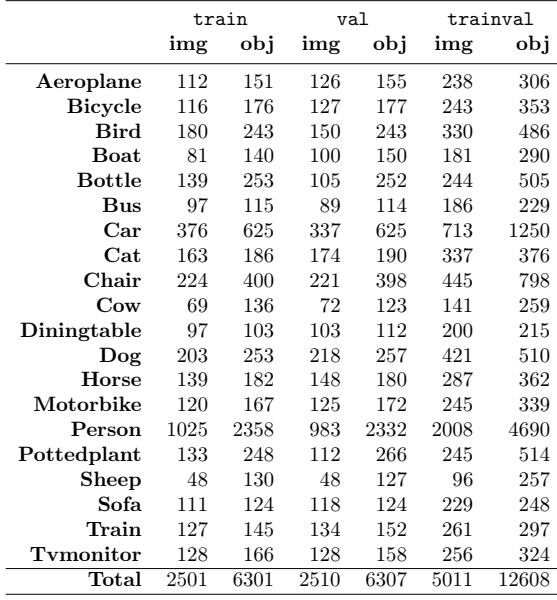

In [ ]:
class YoloTxtDataset(Dataset):
    def __init__(self, images_dir, labels_dir, image_size, S, B, C,
                 names=None, normalize=False, augment=False):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_size = image_size  # (W, H)
        self.S, self.B, self.C = S, B, C
        self.normalize = normalize
        self.augment = augment
        self.names = names if names is not None else list(range(C))

        # Ora Raccolgo la lista di immagini dalla cartella
        exts = "*.jpg" # forse basta jpg dato che sono tutti file di questo tipo
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(self.images_dir, e)))
        self.images = sorted(files)

        def __len__(self):
            return len(self.images)
        

        def _load_labels(self, label_path):
        #Ritorna lista di (cls, x, y, w, h) normalizzati globalmente [0,1].
            if not os.path.exists(label_path):
                return []
            items = []
            with open(label_path, "r", encoding="utf-8") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue # in questo modo se c'è una linea di label mal formata (non con 5 valori) la ignoriamo
                    cid, x, y, w, h = parts
                    cid = int(cid); x = float(x); y = float(y); w = float(w); h = float(h)
                    # ora dobbiamo assicurarci che x, y, w, e h siano numeri positivi e minori di 1 quindi il seguente codice:
                    x = min(max(x, 0.0), 1.0)
                    y = min(max(y, 0.0), 1.0)
                    w = min(max(w, 0.0), 1.0)
                    h = min(max(h, 0.0), 1.0)
                    items.append((cid, x, y, w, h))
            return items


    def __getitem__(self, i):
        img_path = self.images[i]
        stem = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.labels_dir, f"{stem}.txt")

        # apri e ridimensiona (PIL usa (width, height))
        image = Image.open(img_path).convert("RGB")
        W, H = self.image_size  # nel tuo codice IMAGE_SIZE = (W,H)
        image = image.resize((W, H), resample=Image.BILINEAR)

        # --- leggi annotazioni YOLO (global-normalized) ---
        items = self._load_labels(label_path)  # [(cid,x,y,w,h), ...]

        # prepara bbox in pixel (xyxy) per poter applicare affine come fai tu
        boxes_px = []
        for (cid, x, y, w, h) in items:
            cx = x * W; cy = y * H
            ww = w * W; hh = h * H
            x1 = cx - ww / 2; y1 = cy - hh / 2
            x2 = cx + ww / 2; y2 = cy + hh / 2
            boxes_px.append((cid, x1, y1, x2, y2))

        # --- augmentation (stessa logica della tua) ---
        x_shift = int((0.2 * random.random() - 0.1) * W)
        y_shift = int((0.2 * random.random() - 0.1) * H)
        scale = 1 + 0.2 * random.random()

        if self.augment:
            # immagine (può essere PIL)
            image = TF.affine(image, angle=0.0, scale=scale,
                              translate=(x_shift, y_shift), shear=0.0)
            image = TF.adjust_hue(image, 0.2 * random.random() - 0.1)
            image = TF.adjust_saturation(image, 0.2 * random.random() + 0.9)

            # bbox: applica scale+translate attorno al centro immagine
            cx0, cy0 = W / 2.0, H / 2.0
            new_boxes = []
            for (cid, x1, y1, x2, y2) in boxes_px:
                x1 = (x1 - cx0) * scale + cx0 + x_shift
                y1 = (y1 - cy0) * scale + cy0 + y_shift
                x2 = (x2 - cx0) * scale + cx0 + x_shift
                y2 = (y2 - cy0) * scale + cy0 + y_shift
                # clamp
                x1 = max(0.0, min(W - 1.0, x1)); y1 = max(0.0, min(H - 1.0, y1))
                x2 = max(0.0, min(W - 1.0, x2)); y2 = max(0.0, min(H - 1.0, y2))
                if x2 > x1 and y2 > y1:
                    new_boxes.append((cid, x1, y1, x2, y2))
            boxes_px = new_boxes

        # --- torna a normalized global (x,y,w,h ∈ [0,1]) ---
        items_aug = []
        for (cid, x1, y1, x2, y2) in boxes_px:
            ww = max(0.0, x2 - x1); hh = max(0.0, y2 - y1)
            cx = x1 + ww / 2; cy = y1 + hh / 2
            x = cx / W; y = cy / H; w = ww / W; h = hh / H
            if w > 0 and h > 0:
                x = min(max(x, 0.0), 1.0)
                y = min(max(y, 0.0), 1.0)
                w = min(max(w, 0.0), 1.0)
                h = min(max(h, 0.0), 1.0)
                items_aug.append((cid, x, y, w, h))

        # --- tensor + normalize (come fai tu) ---
        data = T.ToTensor()(image)        # (C,H,W) in [0,1]
        original_data = data.clone()      # per il plotting
        if self.normalize:
            data = TF.normalize(data, mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

        # --- costruisci GT SxSx(C+5B) (GLOBAL-normalized!) ---
        depth = self.C + 5 * self.B
        ground_truth = torch.zeros((self.S, self.S, depth), dtype=torch.float32)

        boxes_per_cell = {}
        for (cid, x, y, w, h) in items_aug:
            if cid < 0 or cid >= self.C:
                continue
            col = int(x * self.S)
            row = int(y * self.S)
            if not (0 <= row < self.S and 0 <= col < self.S):
                continue

            # one-hot class
            one_hot = torch.zeros(self.C, dtype=torch.float32)
            one_hot[cid] = 1.0
            ground_truth[row, col, :self.C] = one_hot

            # bbox slot (max B per cella)
            k = boxes_per_cell.get((row, col), 0)
            if k < self.B:
                off = self.C + 5 * k
                ground_truth[row, col, off:off+5] = torch.tensor([x, y, w, h, 1.0], dtype=torch.float32)
                boxes_per_cell[(row, col)] = k + 1

        return data, ground_truth, original_data

### Show some demo images
OPTIONALLY, we could inspect few demo images with the ground-truth bounding boxes

In [ ]:
# Get the dataset
demo_set = YoloTxtDataset('train', normalize=False, augment=True)
print(f"Number of images in the set: {len(demo_set)}")

In [ ]:
#print(f"Shape of the first example: {demo_set[0][0].shape}")
obj_classes = load_class_array()

negative_labels = 0
smallest = 0
largest = 0
example_count = 0
for example, label, original_data in demo_set:
  example_count += 1
  negative_labels += torch.sum(label < 0).item()
  smallest = min(smallest, torch.min(example).item())
  largest = max(largest, torch.max(example).item())
  print(f"Example nr. {example_count}:")
  plot_boxes(example, label, obj_classes, max_overlap=float('inf'))
  print(f"Example's shape: {example.shape}\nLabel's shape: {label.shape}\nOriginal example's shape: {original_data.shape}")
  print(f"Label's support (positions of nonzeros): {torch.nonzero(label)}")
  if example_count >=2:
    break
# print('num_negatives', negative_labels)
# print('dist', smallest, largest)

In [ ]:
# Inspect the label (class probabilities, bounding boxes, confidences) for some cells of last image
print(f"Object class names: {obj_classes}")
print(label[1, 3, 0:5*B+C])
print(label[3, 3, 0:5*B+C])

We can notice that in the label, each 5-tuple of a bounding box has:
 * x-coordinate & y-coordinate of center (relative to the grid cell)
 * width & height (relative to the whole image)
 * confidence

# Loss function

In [ ]:
class SumSquaredErrorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_coord = 5
        self.l_noobj = 0.5
        """
        λ_coord = 5 enfatizza la parte geometrica (posizione e dimensioni).
        𝜆_noobj = 0.5 riduce la penalizzazione dei box “senza oggetto” sulla confidenza (per non sovrastare il resto della loss, dato che sono moltissi
        """

    def forward(self, p, a):
        # Calculate IoU of each predicted bbox against the ground truth b. box
        iou = get_iou(p, a)                     # (batch, S, S, B, B)
        max_iou = torch.max(iou, dim=-1)[0]     # (batch, S, S, B)
# prende, per ciascun box predetto, l’IoU migliore contro i Ground Truth disponibili

        # Get masks
        bbox_mask = bbox_attr(a, 4) > 0.0
        """
        True dove la confidence è positiva (cioè c’è un oggetto),
        False dove la confidence è 0 (cioè non c’è).
        """
        p_template = bbox_attr(p, 4) > 0.0
        """
        Fa esattamente lo stesso ma sulle predizioni del modello.
        bbox_attr(p,4) → prende le confidence predette per ogni box predetto
        Shape (batch, S, S, B_pred).
        Confronto > 0.0 → crea una maschera booleana che dice:
        per ogni cella e per ogni box, se il modello pensa che ci sia un oggetto (confidence > 0).
        """
        obj_i = bbox_mask[..., 0:1]         # 1 if grid I has any object at all
        responsible = torch.zeros_like(p_template).scatter_(       # (batch, S, S, B)
            -1,
            torch.argmax(max_iou, dim=-1, keepdim=True),                # (batch, S, S, B)
            value=1                         # 1 if bounding box is "responsible" for predicting the object
        )
        """
        max_iou è (batch,S,S,B_pred). argmax(..., dim=-1) individua, per ogni cella, quale predicted box ha l’IoU migliore → è il box “responsabile”.
        scatter_ costruisce un tensore one-hot (batch,S,S,B_pred) con 1 nel box responsabile e 0 altrove.
        """
        obj_ij = obj_i * responsible        # 1 if object exists AND bbox is responsible
        noobj_ij = ~obj_ij                  # Otherwise, confidence should be 0

        # XY position losses
        x_losses = mse_loss(
            obj_ij * bbox_attr(p, 0),
            obj_ij * bbox_attr(a, 0)
        )
        y_losses = mse_loss(
            obj_ij * bbox_attr(p, 1),
            obj_ij * bbox_attr(a, 1)
        )
       # annulla tutti i box non responsabili (0·valore = 0). Solo i box giusti contribuiscono alla loss.
        pos_losses = x_losses + y_losses
        # print('pos_losses', pos_losses.item())

        # Bbox dimension losses
        p_width = bbox_attr(p, 2)
        a_width = bbox_attr(a, 2)
        width_losses = mse_loss(
            obj_ij * torch.sign(p_width) * torch.sqrt(torch.abs(p_width) + EPSILON),
            obj_ij * torch.sqrt(a_width)
        )
        p_height = bbox_attr(p, 3)
        a_height = bbox_attr(a, 3)
        height_losses = mse_loss(
            obj_ij * torch.sign(p_height) * torch.sqrt(torch.abs(p_height) + EPSILON),
            obj_ij * torch.sqrt(a_height)
        )
        dim_losses = width_losses + height_losses
        # print('dim_losses', dim_losses.item())
        # È la scelta “classica” di YOLOv1: usare la radice riduce la sensibilità dell’errore per 
        # oggetti grandi e aumenta quella per oggetti piccoli, stabilizzando il training.

        # Confidence losses (target confidence is IoU)
        obj_confidence_losses = mse_loss(
            obj_ij * bbox_attr(p, 4),
            obj_ij * torch.ones_like(max_iou)
        )
        # print('obj_confidence_losses', obj_confidence_losses.item())
        noobj_confidence_losses = mse_loss(
            noobj_ij * bbox_attr(p, 4),
            torch.zeros_like(max_iou)
        )
        # print('noobj_confidence_losses', noobj_confidence_losses.item()

        # Classification losses
        class_losses = mse_loss(
            obj_i * p[..., :C],
            obj_i * a[..., :C]
        )
        # print('class_losses', class_losses.item())

        total = self.l_coord * (pos_losses + dim_losses) \
                + obj_confidence_losses \
                + self.l_noobj * noobj_confidence_losses \
                + class_losses
        return total / BATCH_SIZE


def mse_loss(a, b):
    flattened_a = torch.flatten(a, end_dim=-2)
    """
    appiattisce tutte le dimensioni tranne l’ultima:
    (2, 3, 4) → (6, 4)
    PyTorch fonde insieme la prima e la seconda (2*3 = 6)
    L’ultima (4) rimane invariata.
    Perchè così mantengo i due Bounding Box separati
    """
    flattened_b = torch.flatten(b, end_dim=-2).expand_as(flattened_a)
    return F.mse_loss(
        flattened_a,
        flattened_b,
        reduction='sum' # teniamo solo il numeratore del MSE ovvero non divido per N
    )

# Models

We define two backbone networks:
- ResNet pre-trained on ImageNet-1K dataset: functionalities provided by PyTorch `torchvision.models` sublibrary
- YOLOv1 paper's backbone network, loosely known as Darknet: 24 convolutional + 2 FC layers

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

#################################
#       Transfer Learning       #
#  Use a pre-trained ResNet as  #
#  backbone network             #
#################################
class YOLOv1ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.depth = B * 5 + C
        # depth: numero di canali per cella = 5𝐵+𝐶

        # Load backbone ResNet pretrained on ImageNet-1K
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        # Freeze parameters of backbone network for TRANSFER LEARNING by setting
        # "no need for gradient information" on those paramters
        backbone.requires_grad_(False)

        # Delete last two layers (setting to identity function suits the case)
        # and attach detection layers
        backbone.avgpool = nn.Identity()
        backbone.fc = nn.Identity()
        self.model = nn.Sequential(
            backbone,
            Reshape(2048, 14, 14),
            DetectionNet(2048)   # 4 convolutional + 2 linear layers, as below
        )

    def forward(self, x):
        return self.model.forward(x)


class DetectionNet(nn.Module):
    """The layers added on for detection as described in YOLO paper.
    4 convolutions layers + 2 FC layers with LeakyReLU activation function"""

    def __init__(self, in_channels):
        super().__init__()

        inner_channels = 1024
        self.depth = 5 * B + C
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, stride=2, padding=1),   # (#channels*14*14) -> (#channels*7*7)
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Flatten(),
            nn.Linear(7 * 7 * inner_channels, 4096),
            # nn.Dropout(),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(4096, S * S * self.depth)  # output: S*S*(5B+C)
        )

    def forward(self, x):
        return torch.reshape(
            self.model.forward(x),
            (-1, S, S, self.depth)
        )


###########################
#   YOLOv1 from scratch   #
###########################
class YOLOv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.depth = B * 5 + C

        layers = [
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # Convolutional 1
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),          # Convolutional 2
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 128, kernel_size=1),                    # Convolutional 3
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),         # Convolutional 4
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 256, kernel_size=1),                    # Convolutional 5
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),         # Convolutional 6
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]

        for i in range(4):                                         # Convolutional 7-14
            layers += [
                nn.Conv2d(512, 256, kernel_size=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.LeakyReLU(negative_slope=0.1)
            ]
        layers += [                                                # Convolutional 15-16
            nn.Conv2d(512, 512, kernel_size=1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ]

        for i in range(2):                                         # Convolutional 17-20
            layers += [
                nn.Conv2d(1024, 512, kernel_size=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                nn.LeakyReLU(negative_slope=0.1)
            ]
        layers += [                                                # Convolutional 21-22
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.1)
        ]

        for _ in range(2):                                         # Convolutional 23-24
            layers += [
                nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
                nn.LeakyReLU(negative_slope=0.1)
            ]

        layers += [
            nn.Flatten(),
            nn.Linear(S * S * 1024, 4096),                         # Linear 1
            nn.Dropout(),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(4096, S * S * self.depth),                   # Linear 2
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.reshape(
            self.model.forward(x),
            (x.size(dim=0), S, S, self.depth)
        )


#############################
#       Helper Modules      #
#############################
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = tuple(args)

    def forward(self, x):
        return torch.reshape(x, (-1, *self.shape))

# Training phase

In [ ]:
# Load the dataset
train_set = YoloTxtDataset(
    images_dir=os.path.join(DATA_PATH, SPLIT_TRAIN, "images"),
    labels_dir=os.path.join(DATA_PATH, SPLIT_TRAIN, "labels"),
    image_size=IMAGE_SIZE,
    S=S,
    B=B,
    C=C,
    names=NAMES,
    normalize=True,
    augment=True
)
test_set = YoloTxtDataset(
    images_dir=os.path.join(DATA_PATH, SPLIT_TEST, "images"),
    labels_dir=os.path.join(DATA_PATH, SPLIT_TEST, "labels"),
    image_size=IMAGE_SIZE,
    S=S,
    B=B,
    C=C,
    names=NAMES,
    normalize=True,
    augment=False   # di solito disattivato per test
)

In [ ]:
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    drop_last=True,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    drop_last=True
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# set_detect_anomaly(True) allows for detecting anomaly values in the autograd
# engine. In case of anomaly, such as NaN values, it raises an error showing the
# call stack, to easier debug which operation might have created the invalid
# values. Without setting this global flag, the invalid values would just be
# created and the training might be broken (e.g. if it updates any parameter
# to NaN).
torch.autograd.set_detect_anomaly(True)  # Check for NaN value in loss
writer = SummaryWriter() # for using TensorBoard functionalities
now = datetime.now()     # for timing the execution

model = YOLOv1ResNet().to(device)
# Alternatively, we could use another backbone network: eg. the YOLOv1 defined above.
# model = YOLOv1().to(device)
loss_function = SumSquaredErrorLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE
)
# Adam works better. To use SGD with momentum and weight decay:
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=config.LEARNING_RATE,
#     momentum=0.9,
#     weight_decay=5E-4
# )

# Learning rate scheduler (NOT STRICTLY NEEDED)
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=scheduler_lambda
# )

In [ ]:
# Create folders
root = os.path.join(
    'models',
    'yolo_v1',
    now.strftime('%m_%d_%Y'),
    now.strftime('%H_%M_%S')
)
weight_dir = os.path.join(root, 'weights')
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

# Metrics
train_losses = np.empty((2, 0))
test_losses = np.empty((2, 0))
train_errors = np.empty((2, 0))
test_errors = np.empty((2, 0))


def save_metrics():
    np.save(os.path.join(root, 'train_losses'), train_losses)
    np.save(os.path.join(root, 'test_losses'), test_losses)
    np.save(os.path.join(root, 'train_errors'), train_errors)
    np.save(os.path.join(root, 'test_errors'), test_errors)

In [ ]:
#####################
#       Train       #
#####################
for epoch in tqdm(range(WARMUP_EPOCHS + EPOCHS), desc='Epoch'):
    model.train()
    train_loss = 0
    for data, labels, _ in tqdm(train_loader, desc='Train', leave=False):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model.forward(data)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_loader)
        del data, labels

    # Step and graph scheduler once an epoch
    # writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch)
    # scheduler.step()

    train_losses = np.append(train_losses, [[epoch], [train_loss]], axis=1)
    writer.add_scalar('Loss/train', train_loss, epoch)

    if epoch % 4 == 0:
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for data, labels, _ in tqdm(test_loader, desc='Test', leave=False):
                data = data.to(device)
                labels = labels.to(device)

                predictions = model.forward(data)
                loss = loss_function(predictions, labels)

                test_loss += loss.item() / len(test_loader)
                del data, labels
        test_losses = np.append(test_losses, [[epoch], [test_loss]], axis=1)
        writer.add_scalar('Loss/test', test_loss, epoch)
        save_metrics()
save_metrics()
torch.save(model.state_dict(), os.path.join(weight_dir, 'final'))

Train: 100%|██████████| 78/78 [1:32:47<00:00, 70.15s/it]
                                                        
Test:  62%|██████▏   | 48/78 [40:43<25:13, 50.44s/it]

The metrics have been logged and saved in `runs` (default) directory by TensorBoard during the training.

We can install the tensorboard package and visualize the metrics logged:
 - start TensorBoard, specifying the root log directory you used above.
 - Argument `logdir` points to directory where TensorBoard will look to find event files that it can display. TensorBoard will recursively walk the directory structure rooted at `logdir`, looking for .*tfevents.* files.

In [ ]:
pip install tensorboard

In [ ]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=runs

# Test and draw

In [ ]:
model.eval()
#model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'weights', 'final')))

count = 0
with torch.no_grad():
    for image, labels, original in tqdm(test_loader): # cosa serve tdqm?
        image = image.to(device)
        labels = labels.to(device)
        predictions = model.forward(image)
        for i in range(image.size(dim=0)):
            plot_boxes(
                original[i, :, :, :],
                predictions[i, :, :, :],
                obj_classes,
                file=os.path.join('results', f'{count}')
            )
            # utils.plot_boxes(
            #     original[i, :, :, :],
            #     labels[i, :, :, :],
            #     classes,
            #     color='green'
            # )
            count += 1
        if count>=10:
          break

In [ ]:
%ls -al
#!unzip "Modello YOLO VOC addestrato 50 epoche pytorch state dict.zip"

total 135188
drwxr-xr-x 1 root root      4096 Nov 15 18:13  ./
drwxr-xr-x 1 root root      4096 Nov 15 18:12  ../
drwxr-xr-x 4 root root      4096 Nov 12 14:24  .config/
-rw-r--r-- 1 root root 138412032 Nov 15 18:16 'Modello YOLO VOC addestrato 50 epoche pytorch state dict.zip'
drwxr-xr-x 1 root root      4096 Nov 12 14:25  sample_data/
